In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import glob
from matplotlib.colors import cnames
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook, output_file
from bokeh.models import HoverTool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.cloud import bigquery
import csv
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline
#%matplotlib widget
from google.cloud import bigquery
from google.colab import auth
auth.authenticate_user()

# Étape I : Pré-analyse Features Engineering

## Chargement des fontions

In [6]:
font_size = 3
def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X)
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)
    
    plt.rcParams.update({'font.size': font_size})
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)  # fontsize of the figure title

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        plt.rcParams.update({'font.size': font_size})
        plt.rc('font', size=font_size)          # controls default text sizes
        plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
        plt.rc('axes', labelsize=font_size)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
        plt.rc('legend', fontsize=font_size)    # legend fontsize
        plt.rc('figure', titlesize=font_size)  # fontsize of the figure title
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        plt.rcParams.update({'font.size': font_size})
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            plt.rcParams.update({'font.size': font_size})
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)

## Chargement des données

In [41]:
!gsutil -m cp -r gs://gleeph_eda_hot_eur4/public/damir ./damir/

Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000003.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000001.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000004.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000000.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000000.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000001.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000002.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000004.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000002.parquet...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000003.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000005.csv...
Copying gs://gleeph_eda_hot_eur4/public/damir/damir_201912-000000000005.parquet...
Copying gs://gleeph_eda_hot_

In [ ]:
dirpath = 'path_to_gz_files'   # your directory path
df = pd.concat([pd.read_csv(os.path.join(dirpath, fname))
                for fname in os.listdir(dirpath)], ignore_index=True)

In [34]:
kine = pd.concat(map(pd.read_parquet(encoding='utf-8'), glob.glob('damir/*.csv')))

TypeError: ignored

In [40]:
dirpath = 'damir/'   # your directory path
kine = pd.concat([pd.read_csv(os.path.join(dirpath, fname), encoding='ISO-8859–1')
                for fname in os.listdir(dirpath)], ignore_index=True)

ParserError: ignored

In [10]:
#%%bigquery --project prod-gleeph-eda  kine
#select * FROM `prod-gleeph-eda.prod.damir_122019` as damir where prs_nat = 3125;


ERROR:
 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/prod-gleeph-eda/jobs: Access Denied: Project prod-gleeph-eda: User does not have bigquery.jobs.create permission in project prod-gleeph-eda.

(job ID: aaea8d0e-2851-4dd9-b69f-73330016eb76)

                           -----Query Job SQL Follows-----                           

    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |
   1:select * FROM `prod-gleeph-eda.prod.damir_122019` as damir where prs_nat = 3125;
    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |    .    |


In [4]:
import os
directory = "data"
try:
    os.stat(directory)
except:
    os.mkdir(directory)
directory = "data/damir"
try:
    os.stat(directory)
except:
    os.mkdir(directory)

In [7]:
kine.to_csv('data/damir/kine.csv',quoting=csv.QUOTE_NONNUMERIC,index=False)

AttributeError: ignored

In [ ]:
kine.drop(['FLX_ANN_MOI','string_field_55'], axis=1, inplace=True)

In [ ]:
kine.head(5)

In [ ]:
kine.info()

In [ ]:
kine.isna().sum()

## Version en supprimant les entrées NAN

In [10]:
kine_wo_na = kine.dropna()

## Version qui supprime les variables type "indicateurs"

In [11]:
kinewonawoindic = kine.drop(['FLT_ACT_COG','FLT_ACT_NBR','FLT_ACT_QTE','FLT_DEP_MNT','FLT_PAI_MNT','FLT_REM_MNT','PRS_ACT_COG','PRS_ACT_NBR','PRS_ACT_QTE','PRS_DEP_MNT','PRS_DEP_MNT','PRS_PAI_MNT','PRS_REM_MNT','PRS_REM_BSE'], axis=1)

In [12]:
kinewonawoindic = kine.drop(['FLT_ACT_COG','FLT_ACT_NBR','FLT_ACT_QTE','FLT_DEP_MNT','FLT_PAI_MNT','FLT_REM_MNT','PRS_ACT_COG','PRS_ACT_NBR','PRS_ACT_QTE','PRS_DEP_MNT','PRS_DEP_MNT','PRS_PAI_MNT','PRS_REM_MNT','PRS_REM_BSE','ETP_CAT_SNDS','ETE_CAT_SNDS'], axis=1)

In [13]:
kinewonawoindic = kinewonawoindic.dropna()

# Pandas profiling

In [29]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     - 34.6 MB 89 kB/s
     |████████████████████████████████| 10.1 MB 7.5 MB/s 
     |████████████████████████████████| 596 kB 56.5 MB/s 
     |████████████████████████████████| 102 kB 9.9 MB/s 
     |████████████████████████████████| 675 kB 66.3 MB/s 
     |████████████████████████████████| 4.7 MB 67.6 MB/s 
     |████████████████████████████████| 62 kB 705 kB/s 
     |████████████████████████████████| 812 kB 66.7 MB/s 
     |████████████████████████████████| 28.5 MB 50 kB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261261 sha256=fc7128fd066287b33901f4257dc943b9b98635bb54a077ec8b7f974eb09c3ab8
  Stored in directory: /tmp/pip-ephem-wheel-cache-pc_2r85f/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=af998b817ad83d0421d48cdfbb8025a9be2e46a667f05551890fd087f6882d57
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d25

In [15]:
from pandas_profiling import profile_report
kine_profile = kine.profile_report(title='Pandas profiling Report')

In [16]:
kine_profile.to_file(output_file='kine_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

PicklingError: ignored

# Analyse PCA

## Rapport d'analyse ACP

In [ ]:
pca = PCA(2)
X_pca = pca.fit_transform(kinewonawoindic)
X_pca

array([[-34.37202323, -75.3711316 ],
       [-34.06643771, -15.75643001],
       [-12.47685804,   6.64417456],
       ...,
       [-42.83113701, -73.43613149],
       [-42.69785345, -55.9810613 ],
       [-33.38023452,  88.64331177]])


*--- PCA Report ---*

X mean:		158.268
X variance:	331955.046

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 39 to 22 dimensions while retaining 95% of variance.
2 principal components explain 32.20% of variance.
3 principal components explain 40.20% of variance.


X*X_pca: (39, 678116) * (678116, 39) = (39, 39)


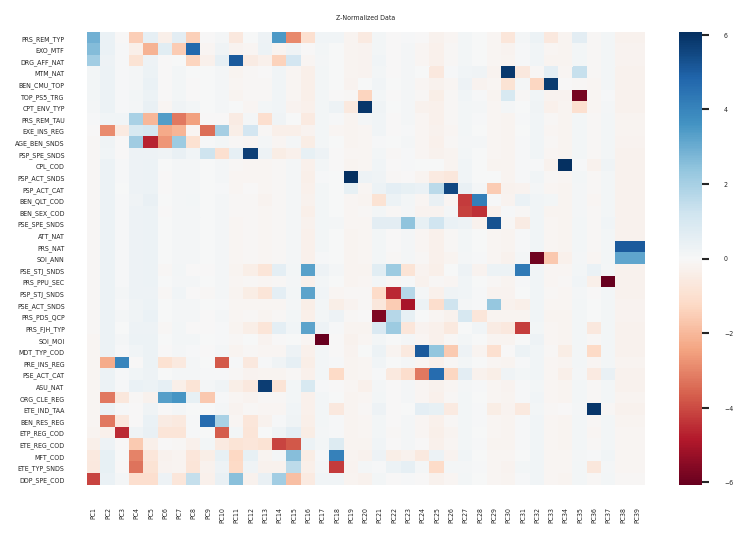

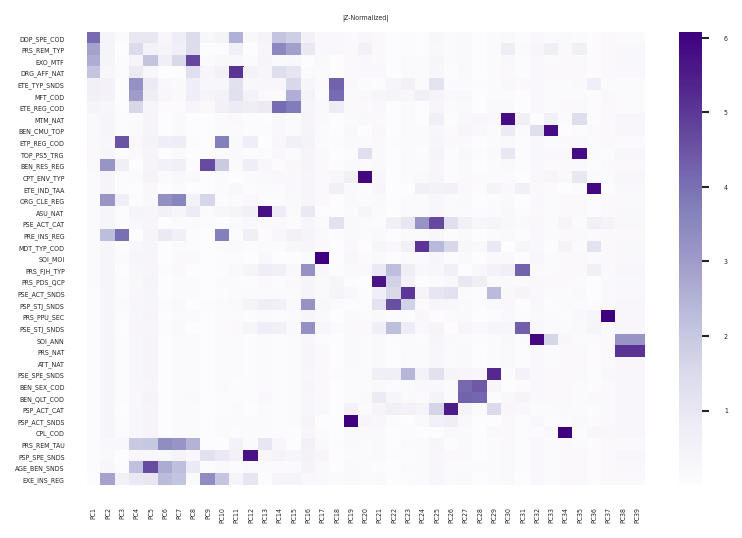

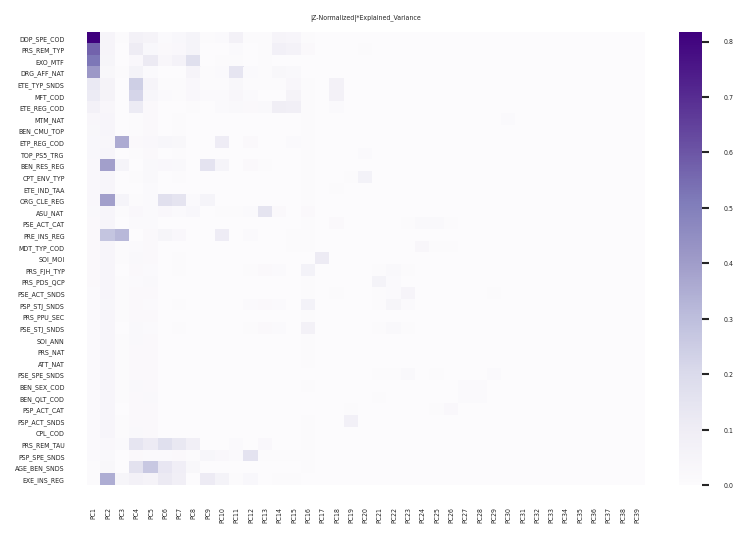

        score_      feature_
rank                        
1     1.343469   DDP_SPE_COD
2     1.086259   PRS_REM_TYP
3     1.055750       EXO_MTF
4     1.003155   EXE_INS_REG
5     0.930882   ORG_CLE_REG
6     0.894359   PRE_INS_REG
7     0.857963   DRG_AFF_NAT
8     0.826270   BEN_RES_REG
9     0.800234   PRS_REM_TAU
10    0.777687  AGE_BEN_SNDS
11    0.746457  ETE_TYP_SNDS
12    0.740414       MFT_COD
13    0.730450   ETP_REG_COD
14    0.572973   ETE_REG_COD
15    0.441419       ASU_NAT
16    0.415294  PSP_SPE_SNDS
17    0.344394  PSP_STJ_SNDS
18    0.311058  PSE_STJ_SNDS
19    0.311048   PRS_FJH_TYP
20    0.272804       SOI_MOI
21    0.258295   CPT_ENV_TYP
22    0.256803  PSE_ACT_SNDS
23    0.253100   PRS_PDS_QCP
24    0.248786   PSE_ACT_CAT
25    0.243751  PSP_ACT_SNDS
26    0.224221   MDT_TYP_COD
27    0.218639  PSE_SPE_SNDS
28    0.210086   PSP_ACT_CAT
29    0.206311   BEN_QLT_COD
30    0.190359   BEN_SEX_COD
31    0.187362       MTM_NAT
32    0.180873   TOP_PS5_TRG
33    0.174469

(           variance_cumulative      variance
 dimension                                   
 1                     0.198327  1.983273e-01
 2                     0.321648  1.233211e-01
 3                     0.401533  7.988462e-02
 4                     0.475658  7.412490e-02
 5                     0.532451  5.679335e-02
 6                     0.583925  5.147424e-02
 7                     0.625864  4.193860e-02
 8                     0.662345  3.648114e-02
 9                     0.695338  3.299323e-02
 10                    0.724529  2.919082e-02
 11                    0.752785  2.825613e-02
 12                    0.780260  2.747416e-02
 13                    0.806365  2.610580e-02
 14                    0.829986  2.362091e-02
 15                    0.852916  2.292955e-02
 16                    0.874452  2.153590e-02
 17                    0.893106  1.865384e-02
 18                    0.910931  1.782574e-02
 19                    0.924242  1.331043e-02
 20                    0.935993  1

In [ ]:
pca_full_report(X=kinewonawoindic.to_numpy(), features_=kinewonawoindic.columns)

In [ ]:
kinewonawoindic = kinewonawoindic[["DDP_SPE_COD","PRS_REM_TYP","EXO_MTF","EXE_INS_REG","ORG_CLE_REG","PRE_INS_REG","DRG_AFF_NAT","BEN_RES_REG","PRS_REM_TAU","AGE_BEN_SNDS","ETE_TYP_SNDS","MFT_COD","ETP_REG_COD","ETE_REG_COD","ASU_NAT","PSP_SPE_SNDS","PSP_STJ_SNDS","PSE_STJ_SNDS","PRS_FJH_TYP","SOI_MOI","CPT_ENV_TYP","PSE_ACT_SNDS"]]

## Standardize values

### Standard Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_pca)
scaler.mean_
X_pca_scaled = scaler.transform(X_pca)
kinewonawoindic_scaled  = scaler.fit(kinewonawoindic).transform(kinewonawoindic)

### Robust Scaler (Gestion des valeurs abérantes)

In [ ]:
transformer = RobustScaler().fit(X_pca)
X_pca_scaled_rb = transformer.transform(X_pca)

## Normalize values
### Normalizer

In [ ]:
nrmlz = Normalizer(norm="max").fit(X_pca_scaled)
X_pca_scaled_and_normalized = nrmlz.transform(X_pca_scaled)

### Power Transformer

In [ ]:
pt = PowerTransformer()
pt.fit(X_pca_scaled)
X_pca_scaled_pt = pt.transform(X_pca_scaled)

In [ ]:
kinewonawoindic.head(5)

,ORG_CLE_REG,AGE_BEN_SNDS,BEN_RES_REG,BEN_CMU_TOP,BEN_QLT_COD,BEN_SEX_COD,DDP_SPE_COD,ETE_CAT_SNDS,ETE_REG_COD,ETE_TYP_SNDS,...,PSE_ACT_SNDS,PSE_ACT_CAT,PSE_SPE_SNDS,PSE_STJ_SNDS,PRE_INS_REG,PSP_ACT_SNDS,PSP_ACT_CAT,PSP_SPE_SNDS,PSP_STJ_SNDS,TOP_PS5_TRG
0,93,60,93,0,1,2,121,9999,99,99,...,26,7,0,1,99,0,0,1,2,1
1,11,20,84,0,1,1,121,9999,99,99,...,26,7,0,1,84,0,1,1,1,1
2,52,80,52,0,1,2,121,9999,99,99,...,26,7,0,1,52,0,1,1,1,1
3,99,80,93,0,1,1,121,9999,99,99,...,26,7,0,1,93,0,1,1,1,1
4,99,50,11,0,1,1,121,9999,99,99,...,26,7,0,9,11,0,1,1,9,1


In [ ]:
f=pd.DataFrame(X_pca_scaled_and_normalized,columns=["x","y"])
f['c'] = kinewonawoindic.AGE_BEN_SNDS
f

,x,y,c
0,0.219784,1.0,60
1,-0.001624,-1.0,20
2,0.056834,-1.0,80
3,-0.022661,-1.0,80
4,0.637774,-1.0,50
...,...,...,...
678111,-0.094842,1.0,50
678112,-0.102122,-1.0,20
678113,-0.103062,-1.0,70
678114,-0.102136,-1.0,70


Text(0.5, 1.0, 'Kine PCA :: Age')

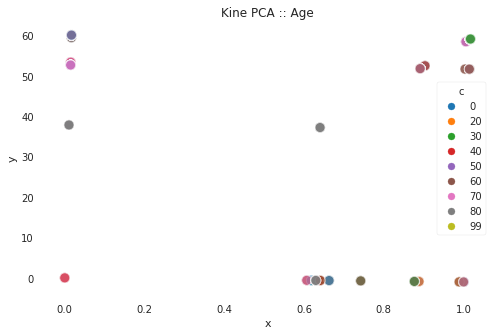

In [ ]:
plt.figure(figsize=(8,5))
s = sns.scatterplot(
    x="x", y="y",
    hue="c",
    palette=sns.color_palette(sns.color_palette("tab10"), n_colors=9),
    data=f,
    s=100,
    legend="full",
    alpha=.5,
)
s.set_title("Kine PCA :: Age")

## Analyse TSNE

In [ ]:
 X_embedded = TSNE(n_components=2, learning_rate=20, n_iter=1000, perplexity=64, n_jobs=-1).fit_transform(kinewonawoindic_scaled[0:100000])

### Sauvegarde du resultat

In [ ]:
np.savetxt("/home/jupyter/data/damir/kine/tsne_kine.csv", X_embedded, delimiter=",")

### Récupération du résultat

In [ ]:
X_embedded_loaded = np.loadtxt(open('/home/jupyter/data/damir/kine/tsne_kine.csv',"rb"), delimiter=",", skiprows=0)

### Vérification du chargement

In [ ]:
X_embedded_loaded.shape

(678115, 2)

In [ ]:
X_embedded.shape

(678116, 2)

In [ ]:
X_embedded == X_embedded_loaded

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

### Visualisation du TSNE

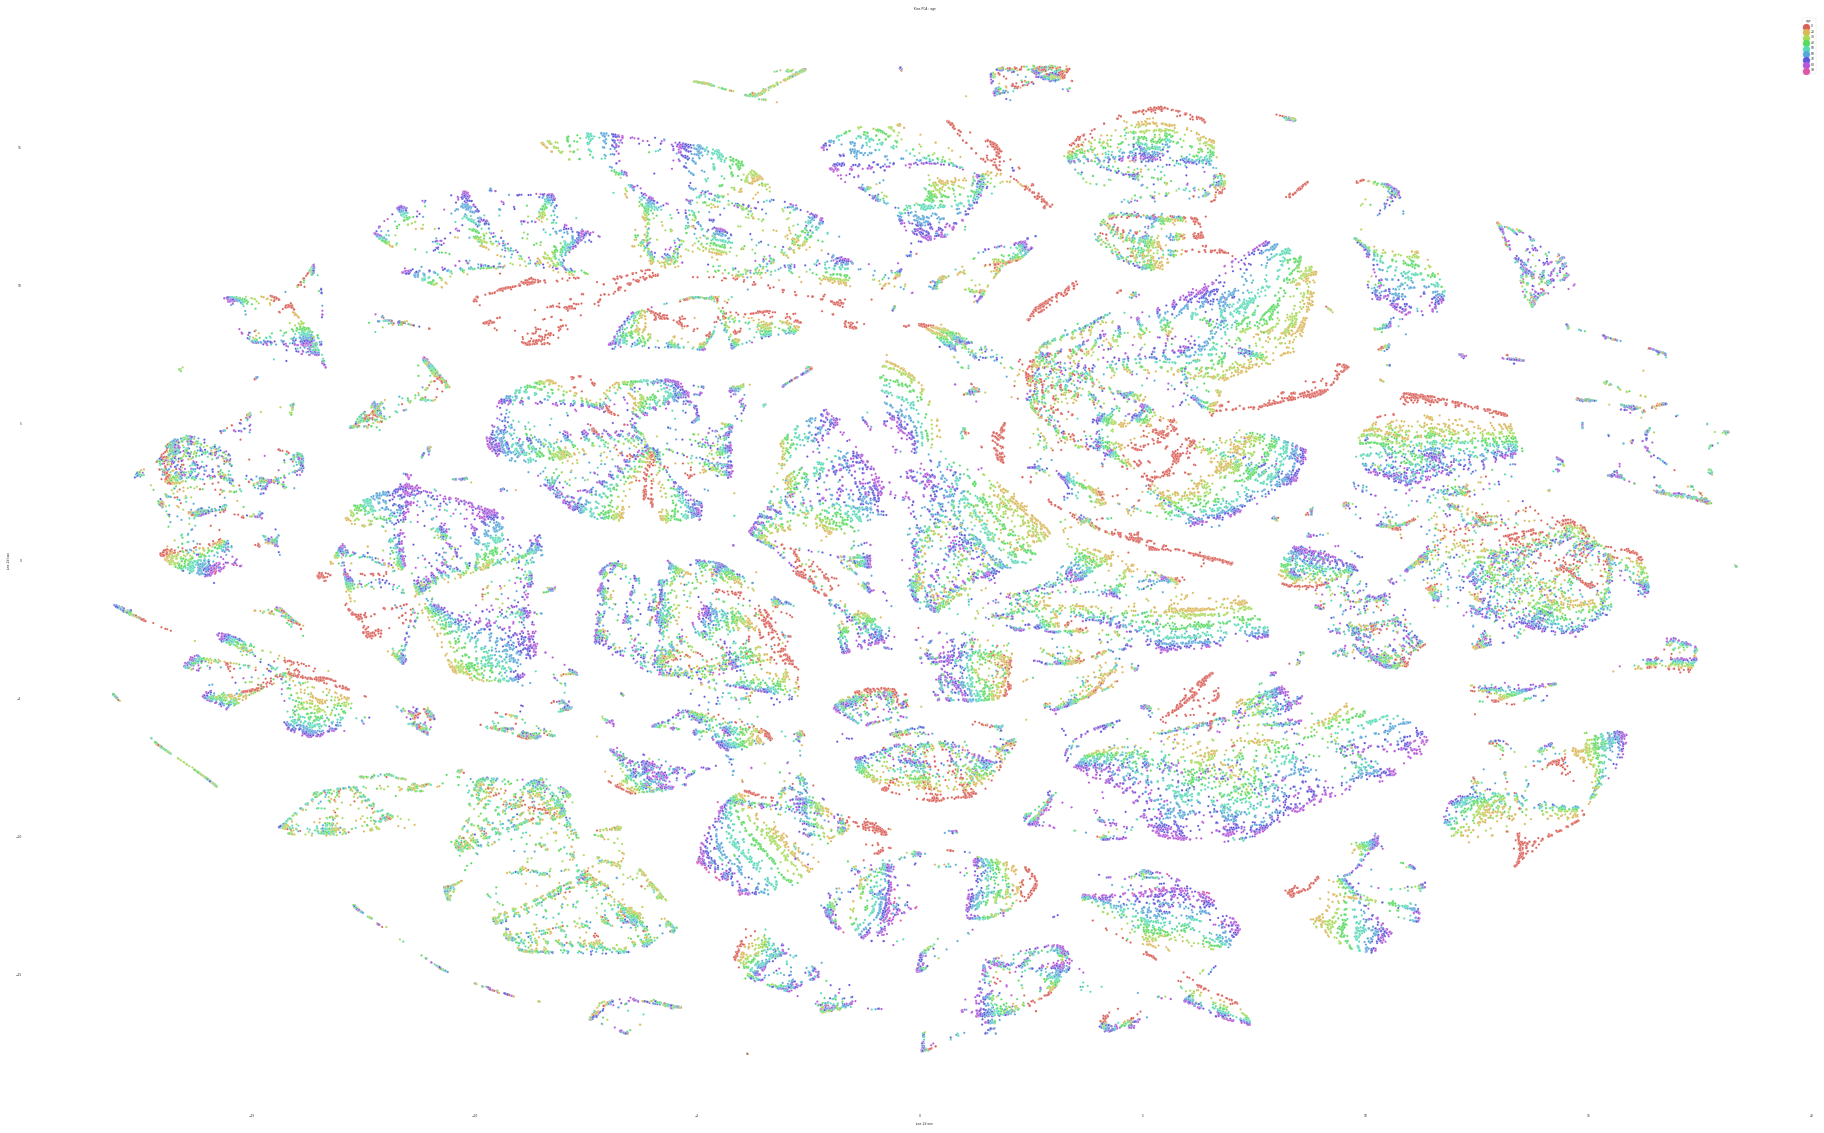

In [ ]:
# my_colors = ['#fffffd00','#fffffe00','#ffffff00','#fffffc00','#990000','#992222']
f=pd.DataFrame()
f['tsne-2d-one'] = X_embedded[:,0]
f['tsne-2d-two'] = X_embedded[:,1]
f['age'] = kinewonawoindic.AGE_BEN_SNDS
plt.figure(figsize=(32,20))
s = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="age",
    palette=sns.color_palette("hls", n_colors=9),
    data=f,
    s=5,
    legend="full",
    alpha=1,
    edgecolors='none',
)
s.set_title("Kine PCA : age")
plt.savefig("/home/jupyter/data/damir/kine/TSNE/kine-pca-age.png")

# Apprentissage supervisé

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.preprocessing import MinMaxScaler

from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.neural_network import MLPClassifier

## Preparation du jeu de données

### Jeux de données avec les ages inconnus

In [ ]:
kine_age_unknow = kinewonawoindic[kine.AGE_BEN_SNDS == 99]
kine_age_unknow.head()

,DDP_SPE_COD,PRS_REM_TYP,EXO_MTF,EXE_INS_REG,ORG_CLE_REG,PRE_INS_REG,DRG_AFF_NAT,BEN_RES_REG,PRS_REM_TAU,AGE_BEN_SNDS,...,ETP_REG_COD,ETE_REG_COD,ASU_NAT,PSP_SPE_SNDS,PSP_STJ_SNDS,PSE_STJ_SNDS,PRS_FJH_TYP,SOI_MOI,CPT_ENV_TYP,PSE_ACT_SNDS
415,121,0,42,93,93,93,35,93,100.0,99,...,99,99,10,1,9,9,8,12,1,26
2849,121,0,0,93,93,93,35,93,60.0,99,...,99,99,10,1,9,9,8,11,1,26
4037,121,0,42,93,93,93,35,93,100.0,99,...,99,99,10,1,9,9,8,9,1,26
5789,121,0,0,93,93,93,35,93,60.0,99,...,99,99,10,1,9,9,8,12,1,26
7100,121,5,0,76,99,99,35,99,40.0,99,...,99,99,10,31,9,9,8,10,7,26


### Jeux de données avec les ages connus

In [ ]:
kine_age_know = kinewonawoindic[kinewonawoindic.AGE_BEN_SNDS != 99]
kine_age_know.head()

,DDP_SPE_COD,PRS_REM_TYP,EXO_MTF,EXE_INS_REG,ORG_CLE_REG,PRE_INS_REG,DRG_AFF_NAT,BEN_RES_REG,PRS_REM_TAU,AGE_BEN_SNDS,...,ETP_REG_COD,ETE_REG_COD,ASU_NAT,PSP_SPE_SNDS,PSP_STJ_SNDS,PSE_STJ_SNDS,PRS_FJH_TYP,SOI_MOI,CPT_ENV_TYP,PSE_ACT_SNDS
0,121,0,0,93,93,99,35,93,60.0,60,...,93,99,10,1,2,1,0,12,1,26
1,121,0,0,84,11,84,35,84,60.0,20,...,99,99,10,1,1,1,0,12,1,26
2,121,0,46,52,52,52,35,52,100.0,80,...,99,99,10,1,1,1,0,10,1,26
3,121,0,0,93,99,93,35,93,60.0,80,...,99,99,10,1,1,1,0,7,1,26
4,121,0,0,11,99,11,35,11,60.0,50,...,99,99,10,1,9,9,8,11,1,26


### Séparation du jeux d'apprentissage entre les variables(x) et la cible(y)

In [ ]:
kine_X = kine_age_know[["DDP_SPE_COD","PRS_REM_TYP","EXO_MTF","EXE_INS_REG","ORG_CLE_REG","PRE_INS_REG","DRG_AFF_NAT","BEN_RES_REG","PRS_REM_TAU","ETE_TYP_SNDS","MFT_COD","ETP_REG_COD","ETE_REG_COD","ASU_NAT","PSP_SPE_SNDS","PSP_STJ_SNDS","PSE_STJ_SNDS","PRS_FJH_TYP","SOI_MOI","CPT_ENV_TYP","PSE_ACT_SNDS"]]

In [ ]:
kine_Y = kine_age_know[["AGE_BEN_SNDS"]]

In [ ]:
kine_X_age_unknow = kine_age_unknow[["PRS_PAI_MNT","ETP_CAT_SNDS","EXE_INS_REG","ORG_CLE_REG","DDP_SPE_COD","EXO_MTF","PRE_INS_REG","BEN_RES_REG","PRS_REM_TAU","PRS_REM_TYP","ETE_CAT_SNDS","ETP_REG_COD","DRG_AFF_NAT","PRS_ACT_QTE","ASU_NAT","PSP_SPE_SNDS","ETE_REG_COD","PSP_STJ_SNDS","PRS_FJH_TYP","PSE_STJ_SNDS","MFT_COD","ETE_TYP_SNDS"]]

### Découpage des jeux en base d'apprentissage et de tests

In [ ]:
kine_X_train, kine_X_test, kine_Y_train, kine_Y_test = train_test_split(kine_X.to_numpy(), kine_Y.to_numpy(), test_size=0.33, random_state=42) 

### Scaling data

In [ ]:
scaler = StandardScaler()
scaler = RobustScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)

## AdaBoost Classifier

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.21984717798217673

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.21948928098493253

## Bagging Classifier

In [ ]:
clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0, n_jobs=-1)

In [ ]:
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train_scaled).score(kine_X_test_scaled, kine_Y_test_scaled)

## Extra Trees Classifier

In [ ]:
clf = ExtraTreesClassifier(n_estimators=9, random_state=0, n_jobs=-1)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.22046902401488852

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.21903296231344618

## Gradient Boosting Classifier

In [ ]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

NameError: name 'GradientBoostingClassifier' is not defined

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

## Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=9, n_jobs=-1)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.23091961633441896

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.22721538241294156

## Stacking Classifier 

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

## Voting Classifier

In [ ]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1, n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
clf3 = GaussianNB()
eclf1 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

In [ ]:
eclf2 = VotingClassifier(estimators=[
                                    ('lr', clf1), 
                                    ('rf', clf2), 
                                    ('gnb', clf3)],
                         voting='soft')
eclf2 = eclf2.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

In [ ]:
eclf3 = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                         voting='soft', weights=[2,1,1],
                         flatten_transform=True)
eclf3 = eclf3.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

In [ ]:
eclf1, eclf2, eclf3

(0.16864553881392935, 0.17513242188898034, 0.17810296696610717)

## History Gradient Boosting

In [ ]:
clf = HistGradientBoostingClassifier()
clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.25452739701513905

In [ ]:
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.24918578433126945

## Complement Naive Bayesian Classifier 

In [ ]:
clf = CategoricalNB()
scaler = MinMaxScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)
#clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

0.16759869009699008

## Categorical Naïve Bayesean Classifier

In [ ]:
clf = ComplementNB()
scaler = MinMaxScaler()
kine_X_train_scaled  = scaler.fit(kine_X_train).transform(kine_X_train)
kine_X_test_scaled  = scaler.fit(kine_X_test).transform(kine_X_test)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)

0.15437439604881714

## Multi-layer Perceptron classifier

In [ ]:
clf = MLPClassifier(random_state=1, max_iter=1000, verbose=True, solver='sgd', learning_rate='adaptive', early_stopping=True).fit(kine_X_train, kine_Y_train)
clf.fit(kine_X_train_scaled, kine_Y_train).score(kine_X_test_scaled, kine_Y_test)
#clf.fit(kine_X_train, kine_Y_train).score(kine_X_test, kine_Y_test)

Iteration 1, loss = 2.16376416
Validation score: 0.155058
Iteration 2, loss = 2.06244968
Validation score: 0.156711
Iteration 3, loss = 2.05027914
Validation score: 0.187163
Iteration 4, loss = 2.00826351
Validation score: 0.186502
Iteration 5, loss = 2.00391039
Validation score: 0.173721
Iteration 6, loss = 2.00133308
Validation score: 0.183703
Iteration 7, loss = 1.99987756
Validation score: 0.188441
Iteration 8, loss = 1.99890120
Validation score: 0.185047
Iteration 9, loss = 1.99784106
Validation score: 0.182645
Iteration 10, loss = 1.99722460
Validation score: 0.186876
Iteration 11, loss = 1.99670813
Validation score: 0.188815
Iteration 12, loss = 1.99608250
Validation score: 0.185863
Iteration 13, loss = 1.99513048
Validation score: 0.187163
Iteration 14, loss = 1.99418228
Validation score: 0.179252
Iteration 15, loss = 1.99211894
Validation score: 0.171011
Iteration 16, loss = 1.99082285
Validation score: 0.188110
Iteration 17, loss = 1.98858519
Validation score: 0.188507
Iterat

0.20472602984860958